In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from scipy.stats import norm
import os
%matplotlib inline

## Bayesian  regression models

In [15]:
class BayesianRegressor:
    def __init__(self,X,y):
        self.X = X
        self.y = y
        self.model = BayesianRidge(normalize=True,copy_X=True)
        self.train = self.transform(self.X)
        
    def transform(self,X):
        return X
    
    def fit(self):
        self.model.fit(self.train,self.y)
        self.V = self.Vn()
    
    def score(self):
        return self.model.score(self.train,self.y)
    
    def plot(self,file=None):
        if file is not None:
            plt.ioff()
        else:
            plt.ion()
        fig, ax = plt.subplots( nrows=1, ncols=1 )
        X_axis = np.linspace(self.X.min(), self.X.max() + 20 , 100)
        X_axis_transformed = self.transform(X_axis)
        ax.scatter(self.X,self.y)
        ax.plot(X_axis,self.model.predict(X_axis_transformed))
        if file is not None:
            fig.savefig(file)
            plt.close(fig)
        else:
            fig.show()
        
    def Vn (self):
        #return np.linalg.inv((np.dot((1/lambd)**2,np.identity(X.shape[1]))) + (1 / alpha**2) * (X.T).dot(X))
        try:
            return np.linalg.inv((1 / self.y.std()**2) * (self.train.T).dot(self.train))
        except np.linalg.LinAlgError:
            return np.linalg.pinv((1 / self.y.std()**2) * (self.train.T).dot(self.train))
    
    #computes estimator for the posterior variance
    def posterior_variance(self,x):
        x_t = self.transform(x)[0]
        return ((self.y.std()**2) + (x_t.T).dot(self.V).dot(x_t))
    
    #computes estimator for the posterior mean
    def posterior_mean(self,x):
        return self.model.predict(res.transform(x)[0].reshape(1,-1))[0]
    
    #return tuple of (posterior_mean,sqrt(posterior_variance))
    def posterior_distribution(self,x):
        return self.posterior_mean(x),np.sqrt(self.posterior_variance(x))
    
    def posterior_cdf(self,y_query,x):
        return norm.cdf(y_query,self.posterior_mean(x),np.sqrt(self.posterior_variance(x)))
    
    def print_stats(self,t,y_query):
        print("R^2:{}".format(self.score()))
        print("posterior std on t = {}: {:.2f}  ".format(t,np.sqrt(self.posterior_variance(t))))
        print("posterior mean on t = {}: {:.0f}".format(t,self.posterior_mean(t)))
        print("goal of {} achieved with probability:{:.2f} ".format(y_query,(1 - self.posterior_cdf(y_query,t))*100))
        
class SqrtRegressor(BayesianRegressor):
    
    def transform(self,X):
        return np.array([np.ones(X.shape),np.sqrt(X)]).T
    
class LogRegressor(BayesianRegressor):
    
    def transform(self,X):
        X_add = X + 1
        return np.array([np.ones(X_add.shape),np.log(X_add)]).T 
    
class CbrtRegressor(BayesianRegressor):
    
    def transform(self,X):
        return np.array([np.ones(X.shape),np.cbrt(X)]).T

## Model selector

In [4]:
def get_best(X,y):
    if y.std() == 0:
        return None
    models = [SqrtRegressor,CbrtRegressor,LogRegressor]
    trained_models = []
    for m in models:
        r = m(X,y)
        r.fit()
        if r.score() > 0.5  and np.all(r.model.coef_ >= 0):
            trained_models.append(r)
    return max(trained_models, key=lambda x:x.score()) if trained_models != [] else None

### Model testing

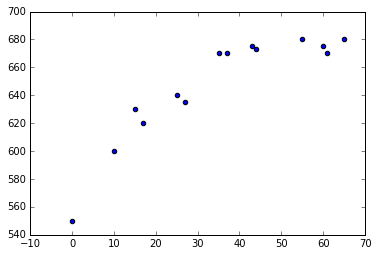

In [6]:
data = pd.read_csv('tests/convergence.csv')
y = data['score']
X = data['date']
plt.scatter(X,y)

R^2:0.9320859236258212
posterior std on t = [90]: 43.63  
posterior mean on t = [90]: 713
goal of 750 achieved with probability:19.59 
R^2:0.9313124052322592
posterior std on t = [90]: 42.02  
posterior mean on t = [90]: 698
goal of 750 achieved with probability:10.90 
R^2:0.922158405650081
posterior std on t = [90]: 41.15  
posterior mean on t = [90]: 689
goal of 750 achieved with probability:6.81 


/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


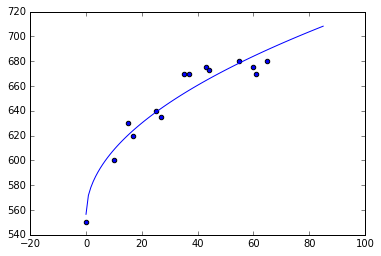

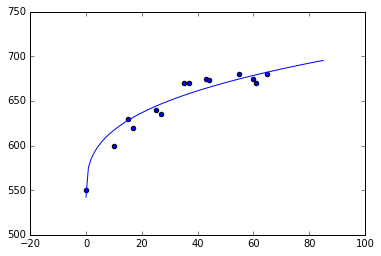

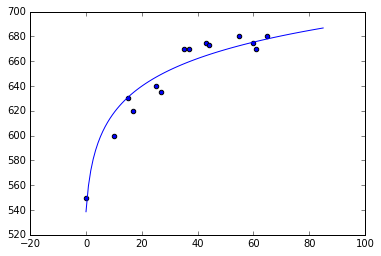

In [7]:
models = [SqrtRegressor,CbrtRegressor,LogRegressor]
for m in models:
    res = m(X,y)
    res.fit()
    res.plot()
    t = 90
    goal = 750
    x = np.array([t,])
    res.print_stats(x,goal)
get_best(X,y)

### Info psu data testing

In [25]:
files = os.listdir('data')
subjects = [1,2,3,6]
files_tuples = list(map(lambda x: tuple(map(lambda y: int(y),x.split(".")[0].strip().split(","))),files))
average_hash = {x:0 for x in subjects}
for subject in subjects:
    filtered = list(filter(lambda x: x[1] == subject,files_tuples))    
    total = 0
    succeses = 0
    for f in filtered:
        data = pd.read_csv('data/{},{}.csv'.format(f[0],f[1]))
        y = data['score']
        X = data['date']
        psu_day = data['psu_day'][0]
        model = get_best(X,y)
        if model is not None:
            success +=1
            succeses +=1
            #model.plot('data/{}.png'.format(f))
            model.print_stats(np.array([90,]),850)
            prediction = model.posterior_mean(np.array([psu_day,]))
            print(prediction)
            total += prediction
    average_hash[subject] = total/succeses
print(average_hash)

R^2:0.9555440692278896
posterior std on t = [90]: 103.45  
posterior mean on t = [90]: 701
goal of 850 achieved with probability:7.46 
823.547523576
R^2:0.9999999999999989
posterior std on t = [90]: 101.78  
posterior mean on t = [90]: 434
goal of 850 achieved with probability:0.00 
444.682052861
R^2:0.9999999999999988
posterior std on t = [90]: 161.83  
posterior mean on t = [90]: 671
goal of 850 achieved with probability:13.39 
685.535289846
R^2:1.0
posterior std on t = [90]: 25.69  
posterior mean on t = [90]: 494
goal of 850 achieved with probability:0.00 
495.571259075
R^2:0.999999999999999
posterior std on t = [90]: 147.70  
posterior mean on t = [90]: 541
goal of 850 achieved with probability:1.81 
553.696865885
R^2:1.0
posterior std on t = [90]: 312.36  
posterior mean on t = [90]: 597
goal of 850 achieved with probability:20.90 
664.16306362
R^2:0.999999999999999
posterior std on t = [90]: 200.86  
posterior mean on t = [90]: 715
goal of 850 achieved with probability:25.08 
73

posterior std on t = [90]: 89.48  
posterior mean on t = [90]: 681
goal of 850 achieved with probability:2.93 
682.952111192
R^2:1.0
posterior std on t = [90]: 160.02  
posterior mean on t = [90]: 590
goal of 850 achieved with probability:5.23 
622.025877368
R^2:0.9999999999999998
posterior std on t = [90]: 67.84  
posterior mean on t = [90]: 519
goal of 850 achieved with probability:0.00 
530.735337412
R^2:0.6424441013288466
posterior std on t = [90]: 49.50  
posterior mean on t = [90]: 618
goal of 850 achieved with probability:0.00 
621.405652636
R^2:0.9993254062976296
posterior std on t = [90]: 21.97  
posterior mean on t = [90]: 597
goal of 850 achieved with probability:0.00 
604.853461439
R^2:0.5369339212326075
posterior std on t = [90]: 48.50  
posterior mean on t = [90]: 609
goal of 850 achieved with probability:0.00 
618.019755443
R^2:0.9999999999999989
posterior std on t = [90]: 79.28  
posterior mean on t = [90]: 546
goal of 850 achieved with probability:0.01 
555.905506874
R

R^2:1.0
posterior std on t = [90]: 206.85  
posterior mean on t = [90]: 674
goal of 850 achieved with probability:19.78 
632.191061905
R^2:1.0
posterior std on t = [90]: 33.07  
posterior mean on t = [90]: 412
goal of 850 achieved with probability:0.00 
413.837561047
R^2:0.9999999999999999
posterior std on t = [90]: 70.31  
posterior mean on t = [90]: 426
goal of 850 achieved with probability:0.00 
432.912950285
R^2:0.7400886602860501
posterior std on t = [90]: 61.17  
posterior mean on t = [90]: 479
goal of 850 achieved with probability:0.00 
476.67945966
R^2:0.9999999999999989
posterior std on t = [90]: 101.64  
posterior mean on t = [90]: 646
goal of 850 achieved with probability:2.25 
648.485578017
R^2:0.9998751282157746
posterior std on t = [90]: 36.86  
posterior mean on t = [90]: 525
goal of 850 achieved with probability:0.00 
570.076911143
R^2:0.9999999999999819
posterior std on t = [90]: 222.04  
posterior mean on t = [90]: 582
goal of 850 achieved with probability:11.41 
629.

R^2:0.7289615321237704
posterior std on t = [90]: 38.43  
posterior mean on t = [90]: 586
goal of 850 achieved with probability:0.00 
589.435383131
R^2:0.9999999999999989
posterior std on t = [90]: 115.96  
posterior mean on t = [90]: 751
goal of 850 achieved with probability:19.76 
762.200857671
R^2:0.9184756779994036
posterior std on t = [90]: 9.39  
posterior mean on t = [90]: 683
goal of 850 achieved with probability:0.00 
684.131785694
R^2:0.9999999999999999
posterior std on t = [90]: 65.67  
posterior mean on t = [90]: 622
goal of 850 achieved with probability:0.03 
620.618647879
R^2:0.708579625552676
posterior std on t = [90]: 76.82  
posterior mean on t = [90]: 522
goal of 850 achieved with probability:0.00 
524.108611264
R^2:0.5568229820076891
posterior std on t = [90]: 68.02  
posterior mean on t = [90]: 592
goal of 850 achieved with probability:0.01 
632.815925291
R^2:0.5654096992450894
posterior std on t = [90]: 42.71  
posterior mean on t = [90]: 658
goal of 850 achieved w

R^2:0.9999999999999999
posterior std on t = [90]: 58.41  
posterior mean on t = [90]: 526
goal of 850 achieved with probability:0.00 
534.027661469
R^2:0.8674911492361318
posterior std on t = [90]: 79.79  
posterior mean on t = [90]: 629
goal of 850 achieved with probability:0.28 
647.971090299
R^2:0.9999999999999999
posterior std on t = [90]: 44.12  
posterior mean on t = [90]: 647
goal of 850 achieved with probability:0.00 
650.687924304
R^2:0.9999999999999989
posterior std on t = [90]: 391.00  
posterior mean on t = [90]: 858
goal of 850 achieved with probability:50.82 
890.719308715
R^2:0.7353824188070939
posterior std on t = [90]: 85.38  
posterior mean on t = [90]: 649
goal of 850 achieved with probability:0.93 
660.069913218
R^2:0.9999999999999998
posterior std on t = [90]: 21.94  
posterior mean on t = [90]: 598
goal of 850 achieved with probability:0.00 
599.34110484
R^2:0.55714129990735
posterior std on t = [90]: 46.70  
posterior mean on t = [90]: 615
goal of 850 achieved wi

R^2:0.9999999999999989
posterior std on t = [90]: 111.06  
posterior mean on t = [90]: 677
goal of 850 achieved with probability:5.92 
686.704395576
R^2:0.5837064821895531
posterior std on t = [90]: 68.05  
posterior mean on t = [90]: 631
goal of 850 achieved with probability:0.06 
758.103503257
R^2:0.9790557685455011
posterior std on t = [90]: 62.35  
posterior mean on t = [90]: 620
goal of 850 achieved with probability:0.01 
689.522830103
R^2:0.9999999999999991
posterior std on t = [90]: 126.49  
posterior mean on t = [90]: 627
goal of 850 achieved with probability:3.92 
752.316823412
R^2:1.0
posterior std on t = [90]: 30.49  
posterior mean on t = [90]: 541
goal of 850 achieved with probability:0.00 
544.074611878
R^2:1.0
posterior std on t = [90]: 31.21  
posterior mean on t = [90]: 495
goal of 850 achieved with probability:0.00 
498.082803605
R^2:0.6874567627686126
posterior std on t = [90]: 115.97  
posterior mean on t = [90]: 775
goal of 850 achieved with probability:25.85 
816.

R^2:0.6289911787023037
posterior std on t = [90]: 84.91  
posterior mean on t = [90]: 636
goal of 850 achieved with probability:0.58 
643.45022266
R^2:0.9999999999999726
posterior std on t = [90]: 100.02  
posterior mean on t = [90]: 500
goal of 850 achieved with probability:0.02 
565.332974372
R^2:0.9354901341562596
posterior std on t = [90]: 63.71  
posterior mean on t = [90]: 519
goal of 850 achieved with probability:0.00 
542.821194116
R^2:1.0
posterior std on t = [90]: 70.48  
posterior mean on t = [90]: 801
goal of 850 achieved with probability:24.41 
782.889730487
R^2:0.9538572656691855
posterior std on t = [90]: 74.78  
posterior mean on t = [90]: 548
goal of 850 achieved with probability:0.00 
557.312625236
R^2:1.0
posterior std on t = [90]: 36.35  
posterior mean on t = [90]: 741
goal of 850 achieved with probability:0.14 
736.813378924
R^2:0.9999999999999999
posterior std on t = [90]: 33.55  
posterior mean on t = [90]: 618
goal of 850 achieved with probability:0.00 
617.285

R^2:0.9999999999999999
posterior std on t = [90]: 497.65  
posterior mean on t = [90]: 1080
goal of 850 achieved with probability:67.79 
753.109614314
R^2:0.9999999999999999
posterior std on t = [90]: 72.46  
posterior mean on t = [90]: 558
goal of 850 achieved with probability:0.00 
564.742884814
R^2:1.0
posterior std on t = [90]: 116.33  
posterior mean on t = [90]: 470
goal of 850 achieved with probability:0.05 
487.233677473
R^2:0.7255882277307077
posterior std on t = [90]: 88.48  
posterior mean on t = [90]: 473
goal of 850 achieved with probability:0.00 
509.070433091
R^2:0.9960509324874132
posterior std on t = [90]: 50.47  
posterior mean on t = [90]: 531
goal of 850 achieved with probability:0.00 
537.796522197
R^2:0.9995525274463711
posterior std on t = [90]: 136.63  
posterior mean on t = [90]: 499
goal of 850 achieved with probability:0.51 
569.828630684
R^2:0.9999999999999998
posterior std on t = [90]: 46.04  
posterior mean on t = [90]: 652
goal of 850 achieved with probab

577.478319626
R^2:0.999999999999993
posterior std on t = [90]: 12.55  
posterior mean on t = [90]: 662
goal of 850 achieved with probability:0.00 
663.684205354
R^2:0.9049299730365893
posterior std on t = [90]: 53.49  
posterior mean on t = [90]: 580
goal of 850 achieved with probability:0.00 
587.762661914
R^2:0.5211977363638636
posterior std on t = [90]: 87.49  
posterior mean on t = [90]: 406
goal of 850 achieved with probability:0.00 
408.391255385
R^2:1.0
posterior std on t = [90]: 22.16  
posterior mean on t = [90]: 530
goal of 850 achieved with probability:0.00 
531.104241677
R^2:0.9999999999999999
posterior std on t = [90]: 50.78  
posterior mean on t = [90]: 506
goal of 850 achieved with probability:0.00 
501.199614604
R^2:0.8954901975188273
posterior std on t = [90]: 61.31  
posterior mean on t = [90]: 674
goal of 850 achieved with probability:0.21 
700.519973538
R^2:0.7146409382901258
posterior std on t = [90]: 50.58  
posterior mean on t = [90]: 553
goal of 850 achieved wit

R^2:0.9999999999999998
posterior std on t = [90]: 66.87  
posterior mean on t = [90]: 575
goal of 850 achieved with probability:0.00 
569.297765053
R^2:0.6116437334921683
posterior std on t = [90]: 52.46  
posterior mean on t = [90]: 653
goal of 850 achieved with probability:0.01 
660.249062153
R^2:0.9999999999999818
posterior std on t = [90]: 172.39  
posterior mean on t = [90]: 518
goal of 850 achieved with probability:2.71 
531.530822873
R^2:1.0
posterior std on t = [90]: 19.98  
posterior mean on t = [90]: 583
goal of 850 achieved with probability:0.00 
596.60200875
R^2:0.9999999999999999
posterior std on t = [90]: 57.19  
posterior mean on t = [90]: 544
goal of 850 achieved with probability:0.00 
557.076570678
R^2:0.943171772474231
posterior std on t = [90]: 48.05  
posterior mean on t = [90]: 638
goal of 850 achieved with probability:0.00 
644.865221344
{1: 588.39353982355192, 2: 638.65053547639559, 3: 499.56007232319325, 6: 568.72512430317033}


### Info psu data testing 